In [15]:
#IMPORT MODULE

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional 
import torch
from torchvision import transforms, models
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torch.nn.init as init
from tqdm import notebook
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [37]:

#HYPERPARAMETERS
#setting all the hyperparameters to their initial values and creating lists of different hyperparmeter values that can be looped through when testing

batch_size = 64
batch_sizes = [64,128,256,512]

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

transformations = [
    #basic normalization transformation
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    #random horizontal flip transformation
    transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    # colour jitter transformation
    transforms.Compose([
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    #random rotation transformation
    transforms.Compose([
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
]

learning_rates = [0.0001,0.001,0.01,0.1]

weight_inits_ = ['xavier_uniform','xavier_normal','kaiming_uniform','kaiming_normal']




#LOAD DATASETS
#load fashionMNIST dataset 
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')



#KFOLD
num_folds = 5
n_samples = len(train_set)
indices = list(range(n_samples))
fold_sizes = [(n_samples // num_folds) for _ in range(num_folds)]

for fold, fold_size in enumerate(fold_sizes):
    start = sum(fold_sizes[:fold])
    stop = start + fold_size
    train_indices = indices[:start] + indices[stop:]
    val_indices = indices[start:stop]



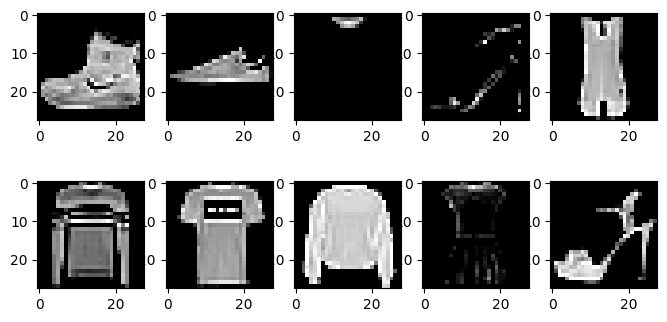

In [17]:
#SHOW DATA EXAMPLE
plt.style.use('default')
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
for i in range(10):
  ax[i % 2, i % 5].imshow(train_set[i][0][0], cmap='gray', vmin=0, vmax=1)
plt.show()

In [18]:
#CREATE CUSTOM NEURAL NETWORK

#A model with 3 fully connected hidden layers and a fully connected output layer
class NN_FullyConnectedLayers(nn.Module):
    def __init__(self):
        super(NN_FullyConnectedLayers, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64 , 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.nn.functional .relu(self.fc1(x))
        x = torch.nn.functional .relu(self.fc2(x))
        x = torch.nn.functional .relu(self.fc3(x))
        x = self.fc4(x)
        return x

nn_fc = NN_FullyConnectedLayers()

#A model with 3 convolutional hidden layers and a fully connected output layer
class  NN_ConvLayers(nn.Module):
    def __init__(self):
        super(NN_ConvLayers, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 3 * 3, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3) 
        x = self.fc(x)
        return x

nn_c = NN_ConvLayers()

#A model with two fully connected hidden layers and one convolutional hidden layer
class NN_TwoFullyConnectedLayersModel(nn.Module):
    def __init__(self):
        super(NN_TwoFullyConnectedLayersModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.pool(torch.nn.functional .relu(self.conv1(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = torch.nn.functional .relu(self.fc1(x))
        x = torch.nn.functional .relu(self.fc2(x))
        x = self.fc3(x)
        return x

nn_twofc = NN_TwoFullyConnectedLayersModel()


#A model with two convolutional hidden layers and one fully connected layer and a fully connected output layer
class NN_TwoConvLayersModel(nn.Module):
  #after test I intialised the weight intialisation to the optimal one which was the kaiming_uniform initialisation
    def __init__(self, weight_init='kaiming_uniform'):
        super(NN_TwoConvLayersModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

        if weight_init == 'xavier_uniform':
            init.xavier_uniform_(self.conv1.weight)
            init.xavier_uniform_(self.conv2.weight)
            init.xavier_uniform_(self.fc1.weight)
            init.xavier_uniform_(self.fc2.weight)
        elif weight_init == 'xavier_normal':
            init.xavier_normal_(self.conv1.weight)
            init.xavier_normal_(self.conv2.weight)
            init.xavier_normal_(self.fc1.weight)
            init.xavier_normal_(self.fc2.weight)

        elif weight_init == 'kaiming_uniform':
            init.kaiming_uniform_(self.conv1.weight)
            init.kaiming_uniform_(self.conv2.weight)
            init.kaiming_uniform_(self.fc1.weight)
            init.kaiming_uniform_(self.fc2.weight)
        elif weight_init == 'kaiming_normal':
            init.kaiming_normal_(self.conv1.weight)
            init.kaiming_normal_(self.conv2.weight)
            init.kaiming_normal_(self.fc1.weight)
            init.kaiming_normal_(self.fc2.weight)
        else:
            raise ValueError(f"Unknown weight initialization: {weight_init}")

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


nn_twoc = NN_TwoConvLayersModel()

#a dictionary of all the models for testing 
model_dict = {
    'ALL Convolutional Layers': nn_c,
    'All Layers Fully Connected' : nn_fc,
    'Two Fully Connected Layers , One Convolutional' : nn_twofc,
    'Two Convolutional Layers, One Fully Connected' : nn_twoc
}

In [19]:
def get_train_val_split(train_data, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    return list(kfold.split(train_data))

In [20]:
def run_model_crossval(model, train_set, num_epochs=10, learning_rate=0.01, momentum=0.9, n_splits=5):
    # Define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer_SGD = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # set up k-fold cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_accuracies = [] 
    fold_losses = []  

    for fold, (train_indices, val_indices) in enumerate(kfold.split(train_set), start=1):
        print(f"Running fold {fold}...")

        # split the training into training and validation subsets 
        train_subset = torch.utils.data.Subset(train_set, train_indices)
        val_subset = torch.utils.data.Subset(train_set, val_indices)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)

        # set the model to training mode
        model.train()
        for epoch in notebook.tqdm(range(num_epochs), desc='Epochs'):
            running_loss = 0.0
            for i, data in enumerate(train_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer_SGD.zero_grad()
                outputs = model(inputs)
                # compute loss
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer_SGD.step()

                # add loss over the epoch
                running_loss += loss.item()

            # average loss 
            running_loss /= len(train_loader)
            print(f"Epoch: {epoch+1}, Loss: {running_loss:.4f}")

        # set model to evaluation mode
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # compute accuracy for this fold and print
        accuracy = 100 * correct / total
        print(f"Fold {fold} accuracy: {accuracy:.2f}%")

        # store accuracy and loss for this fold
        fold_accuracies.append(accuracy)
        fold_losses.append(running_loss)

    # calculate tge average accuracy and loss over all folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_loss = np.mean(fold_losses)

    print(f"Cross-Validation Accuracy: {avg_accuracy:.2f}%, Average Loss: {avg_loss:.4f}")


In [21]:
def run_model(model,learning_rate = 0.01, num_epochs =10, momentum=0.9, n_splits=5):
    # Define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer_SGD = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer_SGD, step_size=30, gamma=0.1)
    epplot = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device_gpu = torch.device("gpu")
    model.to(device)
    total_epochs = notebook.tqdm(range(num_epochs))


  #TRAIN NEURAL NETWORK
    #set model to train
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer_SGD.zero_grad()

            outputs = model(inputs)
            #print(f"Output shape: {outputs.shape}") 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_SGD.step()
            #add to loss
            running_loss += loss.item()
            #display loss
            total_epochs.set_description(
                  'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                      epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))
        #step learning rate schedular
        #scheduler.step() 
        running_loss = running_loss / (i + 1)
        #add to plot list
        epplot.append(running_loss)
        #display epoch and loss
        print(f"Epoch: {epoch+1}, Loss: {running_loss:.4f}") 


  #TEST NEURAL NETWORK
    #put model in eval mode
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy =  100 * correct / total
    #display accuracy
    print(f"Accuracy: {accuracy:.2f}%")
    return epplot
    

In [ ]:
#use cross val on a model
def run_crossval_model(model):
  trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
  testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
  classes = ('t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')

  run_model_crossval(model,trainset)

run_crossval_model(NN_TwoConvLayersModel())

In [ ]:
#TEST ALL MODELS
def test_models(model_dict):
  #loop through all models in the dictionary
  for model_name, model in model_dict.items():
    print(model_name)
    #run the current model
    plot = run_model(model)
    #plot on graph
    plt.plot(plot, label = str(model_name))

  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Effect of Architecture on loss")
  plt.show()

test_models(model_dict)

In [ ]:
#TEST ALL LEARNING RATES
def test_learning_rates(learning_rates):
  #loop through learning rates
  for i, lr in enumerate(learning_rates):
      model_test = NN_TwoConvLayersModel()
      #run model with given learning rate
      plot = run_model(model_test, learning_rate = lr)
      #plot on graph
      plt.plot(plot, label = str(lr))
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
  
  plt.title("Loss vs. Learning Rate for lr")
  plt.tight_layout()
  plt.show()

test_learning_rates(learning_rates)

In [ ]:
#TEST WEIGHT INITS
def test_weight_inits(weight_inits_):
  #loop through all the weight inits
  for i, weight in enumerate(weight_inits_):
    print(weight)
    #apply the weight init to the model
    model_test = NN_TwoConvLayersModel(weight_init = weight)
    #run model
    plot = run_model(model_test)
    #plot graph
    plt.plot(plot, label = str(weight))

  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Effect of Weight Initialisations on Loss")
  plt.show()

test_weight_inits(weight_inits_)


In [ ]:
#TEST ALL TRANSFORMATIONS
def test_augmentations(transformations):

  for i, tf in enumerate(transformations):
    #get names for transformations
    string = ""
    if i == 0:
        string = "Regular"
    elif i == 1:
        string = "Random Horizontal Flip"
    elif i == 2:
        string = "Color Jitter"
    elif i == 3:
        string = "Random Rotation"

    #redownload dataset with the chosen transformation applied
    train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=tf)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

    test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=tf)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

    classes = ('t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
    #run model
    model_test = NN_TwoConvLayersModel()
    #plot graph
    plot = run_model(model_test)
    plt.plot(plot, label = str(string))

  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Effect of Transformations on Loss")
  plt.show()
 
test_augmentations(transformations)




In [ ]:
#TEST ALL BATCH SIZES
def test_batch_sizes(batch_sizes):
  for bs in batch_sizes:
    #redownload training set while changing the batch_size
    train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=0)

    test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs, shuffle=False, num_workers=0)

    classes = ('t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
    #run the model
    model_test = NN_TwoConvLayersModel()
    #plot the graph
    plot = run_model(model_test)
    plt.plot(plot, label = str(bs))

  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Effect of Batch Size on Loss")
  plt.show()

test_batch_sizes(batch_sizes)



In [35]:
def preprocess_ResNet():
   preprocess = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # FashionMNIST is grayscale, convert to 3-channel
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
   return preprocess

In [47]:
def neuron_activities(model,test_loader):
  features = []
  with torch.no_grad():
    for inputs, _ in test_loader:
      inputs = inputs.to('cuda')
      outputs = model(inputs)
      features.extend(outputs.cpu().numpy().reshape(outputs.shape[0], -1))

  features = np.array(features)
  return features


In [48]:
def compare_with_ResNet(model):
  #preprocess ResNet dataset
  preprocess =preprocess_ResNet()
  test_set = FashionMNIST(root='./data', train=False, download=True, transform=preprocess)

  # select 100 images from each class
  indices = []
  for i in range(10):
      class_indices = (test_set.targets == i).nonzero(as_tuple=True)[0]
      indices.extend(class_indices[:100].tolist())
  subset_test_set = Subset(test_set, indices)

  # create DataLoader
  test_loader = DataLoader(subset_test_set, batch_size=10, shuffle=False)

  # load pre-trained ResNet-18 model
  resnet18 = models.resnet18(pretrained=True)

  # remove the last layer for feature extraction
  resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1]))

  resnet18.eval()  
  resnet18 = resnet18.to('cuda')  

  # compute neuron activities
  features = neuron_activities(resnet18,test_loader)
 

  # compute correlation matrix
  corr_matrix_resnet = np.corrcoef(features.T)
  print("ResNet-18 Correlation Matrix Shape:", corr_matrix_resnet.shape)
  print("============================================")

  # modify the first layer of your model to accept 3-channel input
  model.conv1 = torch.nn.Conv2d(3, model.conv1.out_channels, kernel_size=model.conv1.kernel_size, 
                                  stride=model.conv1.stride, padding=model.conv1.padding, 
                                  dilation=model.conv1.dilation, groups=model.conv1.groups, 
                                  bias=model.conv1.bias is not None)

  model = model.to('cuda')
  model.eval()

  # compute neuron activities for my custom model
  features_model = neuron_activities(model,test_loader)
 

  # compute correlation matrix for my custom mode
  corr_matrix_your_model = np.corrcoef(features_model.T)
  print("Your Model Correlation Matrix Shape:", corr_matrix_your_model.shape)

  # compute the mean and standard deviation of the correlation matrices
  mean_corr_resnet = np.mean(corr_matrix_resnet)
  std_corr_resnet = np.std(corr_matrix_resnet)
  mean_corr_your_model = np.mean(corr_matrix_your_model)
  std_corr_your_model = np.std(corr_matrix_your_model)

  print("ResNet-18 Correlation Mean:", mean_corr_resnet, "Standard Deviation:", std_corr_resnet)
  print("Your Model Correlation Mean:", mean_corr_your_model, "Standard Deviation:", std_corr_your_model)


compare_with_ResNet(NN_TwoConvLayersModel())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet-18 Correlation Matrix Shape: (512, 512)
Your Model Correlation Matrix Shape: (10, 10)
ResNet-18 Correlation Mean: 0.022130002433291416 Standard Deviation: 0.1640979494190549
Your Model Correlation Mean: 0.08295415179842504 Standard Deviation: 0.4048674288609988
